In [9]:
import os

import numpy as np
import pandas as pd
import scipy
# import polars as pl # Prove this is quickler
import matplotlib.pyplot as plt

import astropy
 
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import lightning as L

from tqdm.auto import tqdm

from preprocess_light_curve import *

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
def crossmatch_object_alerce(alerce_lc: pd.DataFrame, object: pd.DataFrame) -> pd.DataFrame:
    lightcurves = pd.merge(left=alerce_lc, right=object,
                       on='oid')
    return lightcurves

def process_light_curve_parsnip(ligth_curve):

    new_light_curve = ligth_curve.copy()

    SIDEREAL_SCALE = 86400. / 86164.0905

    time = ligth_curve['mjd'].to_numpy()
    sidereal_time = time * SIDEREAL_SCALE

    # Initial guess of the phase. Round everything to 0.1 days, and find the decimal
    # that has the largest count.
    mode, count = scipy.stats.mode(np.round(sidereal_time % 1 + 0.05, 1), keepdims=True)
    guess_offset = mode[0] - 0.05

    # Shift everything by the guessed offset
    guess_shift_time = sidereal_time - guess_offset

    # Do a proper estimate of the offset.
    sidereal_offset = guess_offset + np.median((guess_shift_time + 0.5) % 1) - 0.5

    # Shift everything by the final offset estimate.
    shift_time = sidereal_time - sidereal_offset

    # Selecting the 
    s2n = ligth_curve['magpsf'] / ligth_curve['sigmapsf']
    s2n_mask = np.argsort(s2n)[-5:]

    cut_times = shift_time[s2n_mask]

    max_time = np.round(np.median(cut_times))

    # Convert back to a reference time in the original units. This reference time
    # corresponds to the reference of the grid in sidereal time.
    reference_time = ((max_time + sidereal_offset) / SIDEREAL_SCALE)
    grid_times = (time - reference_time) * SIDEREAL_SCALE
    time_indices = np.round(grid_times).astype(int) + 300 // 2 # 300 days
    time_mask = (
        (time_indices >= -100)
        & (time_indices < 300 + 100)
    )
    new_light_curve['grid_time'] = grid_times
    new_light_curve['time_index'] = time_indices
    new_light_curve = new_light_curve[time_mask]

    return new_light_curve  

def create_grid(light_curves):

    redshifts = []
    compare_data = []

    #lightcurve = process_light_curve_parsnip(lightcurve)
    
    # Build a grid for the input
    # The first grid is created for saved the data
    # The second grid is created for save the weights that will be used
    # on the loss_function
    len_light_curves = len(light_curves.oid.unique())
    print(len_light_curves)
    grid_flux    = np.zeros(len_light_curves,1,300))
    grid_weights = np.zeros_like(grid_flux) 

    for idx, light_curve in enumerate(light_curves): 
        print(light_curve)
        mask = (light_curve['time_index'] >= 0) & (light_curve['time_index'] < 300)
        
        light_curve = light_curve.loc[mask]

        redshifts.append(0.1)
        # This value is normally in other file
        error_floor = 0.01
        weights = 1 / (light_curve['magpsf']**2 + error_floor**2)


        #magnitudes = lightcurve.magpsf.to_numpy()
        #lightcurve.loc[:, 'flux'] = 10 * (0.4 * (48.6 - magnitudes))    
    
        # Fill in the input array.
        #grid_flux[0, :] = np.linspace(0,300,300)
        #grid_flux[1, lightcurve['time_index']] = lightcurve['flux'].to_numpy()
        grid_flux[idx, 1, light_curve['time_index']] = light_curve['magpsf']


        # Fill the grid weights
        #print(len(weights))
        #print(len(lightcurve['time_index']))
        grid_weights[idx, 1, light_curve['time_index']] = error_floor**2 * weights


        obj_compare_data = torch.FloatTensor(np.vstack([
                    light_curve['grid_time'],
                    light_curve['magpsf'],
                    light_curve['sigmapsf'],
                    weights,
                ]))
        
    redshifts = np.array(redshifts)
    extra_input_data = [redshifts]

    input_data = np.concatenate(
            [i[:, None, None].repeat(300, axis=2) for i in extra_input_data]
            + [grid_flux, grid_weights],
            axis=1
        )
    
    print(input_data)

    #input_data = np.concatenate(
    #        [i[:, None, None].repeat(self.settings['time_window'], axis=2) for i in extra_input_data] + [grid_flux, grid_weights], axis=1
    #    )

    return grid_flux, grid_weights

SyntaxError: unmatched ')' (482545433.py, line 65)

In [11]:
def plot_light_curve(light_curve, oid:any = None):

    time = light_curve['mjd'].to_numpy()
    mag  = light_curve['magpsf'].to_numpy()

    fig, ax = plt.subplots()
    ax.plot(time,mag,'o')
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    ax.set_ylim(ax.get_ylim()[::-1])

    if oid != None:
        ax.set_title(f'oid: {oid}')

In [12]:
object_table = pd.read_pickle('~/Supernovae_DeepLearning/object_ZTF_ALeRCE_19052024.pkl')
object_table

,oid,source_id,firstmjd,Av_MW,true_label
0,ZTF24aanbjel,2024iqx,60440.299120,0.0287,SN
1,ZTF24aamkufg,2024igh,60437.289560,0.0261,SNIa
2,ZTF24aajnwwr,2024hqr,60429.209850,0.0509,SNIa
3,ZTF18aaeopbs,2024glo,60407.202211,0.1403,SNIa
4,ZTF24aamtsgz,2024ipf,60438.397951,0.2484,SNIa
...,...,...,...,...,...
10868,ZTF19aamqjsh,2016cda,58558.284549,0.0447,SNIa
10869,ZTF18aarefgc,2016bey,60315.469572,0.0355,SNIa
10870,ZTF18aajleyh,2016ayf,58276.285139,0.0533,SNIa
10871,ZTF22abntkbk,2016nx,59870.374664,0.5834,SNIa


In [13]:
lightcurves_alercextns = pd.read_pickle('/home/jurados/Supernovae_DeepLearning/data/lightcurves/lcs_transients_20240517.pkl')
lightcurves_alercextns

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf
0,ZTF19abgpgyp,1515523874715015006,681120247.0,59269.523877,2,20.385720,0.211641
1,ZTF19abgpgyp,1499511354715015014,NaN,59253.511354,2,20.678400,0.258971
2,ZTF19abgpgyp,1502430264715015014,NaN,59256.430266,2,20.652500,0.269586
3,ZTF19abgpgyp,1510536184715015009,NaN,59264.536181,2,20.663600,0.299923
4,ZTF18abjswhy,1515520891415015005,685120214.0,59269.520891,2,16.079460,0.030863
...,...,...,...,...,...,...,...
4546324,ZTF19ablwbut,1508538592115015009,NaN,59262.538599,1,17.079200,0.062217
4546325,ZTF19ablwbut,1511512652115015011,NaN,59265.512651,1,17.125100,0.057529
4546326,ZTF19ablwbut,1513537042115015020,NaN,59267.537049,1,17.073800,0.073881
4546327,ZTF19ablwbut,1515495032115015010,NaN,59269.495035,1,17.232900,0.056399


In [14]:
# Here I realized a crossmatch between all lightcurves_alercextns and
# the object table
lightcurves = crossmatch_object_alerce(lightcurves_alercextns, object_table)
lightcurves

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label
0,ZTF19abgpgyp,1515523874715015006,681120247.0,59269.523877,2,20.385720,0.211641,2019lkw,58681.194086,0.0608,SNII
1,ZTF19abgpgyp,1499511354715015014,NaN,59253.511354,2,20.678400,0.258971,2019lkw,58681.194086,0.0608,SNII
2,ZTF19abgpgyp,1502430264715015014,NaN,59256.430266,2,20.652500,0.269586,2019lkw,58681.194086,0.0608,SNII
3,ZTF19abgpgyp,1510536184715015009,NaN,59264.536181,2,20.663600,0.299923,2019lkw,58681.194086,0.0608,SNII
4,ZTF19aatubsj,1515535253915015003,634120239.0,59269.535255,2,20.251050,0.161910,2019fdr,58605.400428,0.1393,SLSN
...,...,...,...,...,...,...,...,...,...,...,...
311883,ZTF18aavtvxx,1515516622515010002,826120225.0,59269.516620,2,18.331059,0.091234,2018mc,58255.410312,0.0965,SNIIb
311884,ZTF20acgyjbh,1515521513815015012,483120238.0,59269.521516,2,19.333435,0.109986,2020vck,59128.149931,0.3555,SNII
311885,ZTF20acgyjbh,1513527463815015004,NaN,59267.527465,1,20.057800,0.273645,2020vck,59128.149931,0.3555,SNII
311886,ZTF20acgyjbh,1515466313815015003,NaN,59269.466319,1,20.268000,0.402365,2020vck,59128.149931,0.3555,SNII


In [15]:
lightcurves = lightcurves[lightcurves.fid == 1]
lightcurves.oid.unique().size

7913

In [16]:
print('The oid of transients with maximum length is:', lightcurves.groupby(by='oid')['mjd'].size().idxmax())
print('The maximum length of observation is:', lightcurves.groupby(by='oid')['mjd'].size().max())

The oid of transients with maximum length is: ZTF18aainvic
The maximum length of observation is: 816


In [17]:
def pad_zeros(group, max_length=1730):
    
    group_length = len(group)

    if group_length < max_length:
        extra_rows = max_length - group_length
        extra_data = pd.DataFrame({
            'oid': [group['oid'].iloc[0]] * extra_rows,
            'mag': [0] * extra_rows
        })
        group = pd.concat([group, extra_data], ignore_index=True)

    return group

In [18]:
sn_unique = lightcurves.oid.unique()
selected_unique_values = np.random.choice(sn_unique, int(0.8 * len(sn_unique)), replace=False)
selected_unique_values_test = np.random.choice(sn_unique, int(0.2 * len(sn_unique)), replace=False)

In [19]:
train_data = lightcurves[lightcurves.oid.isin(selected_unique_values)]
test_data = lightcurves[lightcurves.oid.isin(selected_unique_values_test)]

In [20]:
train_data

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label
7,ZTF20acqqdkl,1512141441415015002,NaN,59266.141447,1,19.452000,0.241100,2020aafb,59168.215486,0.2383,SNIIn
8,ZTF20acqqdkl,1514156581415015006,NaN,59268.156586,1,19.360500,0.221674,2020aafb,59168.215486,0.2383,SNIIn
9,ZTF20acphdcg,1516233550015015020,614120100.0,59270.233553,1,17.273174,0.051715,2020znr,59155.411944,0.1621,SLSN
10,ZTF18abrqedj,1516233554415010006,614120144.0,59270.233553,1,18.617750,0.132642,2018fqz,58359.467222,0.2047,SNIa
11,ZTF21aaizyqc,1516279976215015002,712120162.0,59270.279977,1,18.487911,0.128522,2021ckb,59252.390880,0.0445,SNII
...,...,...,...,...,...,...,...,...,...,...,...
311875,ZTF18aainvic,1515488221515010003,681120115.0,59269.488229,1,19.248486,0.140085,2018jo,58243.316123,0.1481,SNII
311876,ZTF21aafdxca,1515496946215015004,486120162.0,59269.496944,1,17.409678,0.046209,2021apf,59230.557153,0.6202,SNIa
311881,ZTF21aaaigfg,1513527005515015002,NaN,59267.527002,1,20.185900,0.240722,2021ag,59216.559722,0.2114,SNIa
311885,ZTF20acgyjbh,1513527463815015004,NaN,59267.527465,1,20.057800,0.273645,2020vck,59128.149931,0.3555,SNII


In [21]:
print('The oid of transients with maximum length is:', train_data.groupby(by='oid')['mjd'].size().idxmax())
print('The maximum length of observation is:', train_data.groupby(by='oid')['mjd'].size().max())

The oid of transients with maximum length is: ZTF18aainvic
The maximum length of observation is: 816


In [22]:
test = train_data.copy()
test = test[['oid','mjd','magpsf']]
test

,oid,mjd,magpsf
7,ZTF20acqqdkl,59266.141447,19.452000
8,ZTF20acqqdkl,59268.156586,19.360500
9,ZTF20acphdcg,59270.233553,17.273174
10,ZTF18abrqedj,59270.233553,18.617750
11,ZTF21aaizyqc,59270.279977,18.487911
...,...,...,...
311875,ZTF18aainvic,59269.488229,19.248486
311876,ZTF21aafdxca,59269.496944,17.409678
311881,ZTF21aaaigfg,59267.527002,20.185900
311885,ZTF20acgyjbh,59267.527465,20.057800


In [23]:
one_light_curve = train_data[train_data.oid == train_data.oid.unique()[3]]
one_light_curve

,oid,candid,rfid,mjd,fid,magpsf,sigmapsf,source_id,firstmjd,Av_MW,true_label
11,ZTF21aaizyqc,1516279976215015002,712120162.0,59270.279977,1,18.487911,0.128522,2021ckb,59252.39088,0.0445,SNII
12,ZTF21aaizyqc,1516280455115015002,711120151.0,59270.280451,1,18.655172,0.147987,2021ckb,59252.39088,0.0445,SNII
57,ZTF21aaizyqc,1518393625115015001,711120151.0,59272.393623,1,18.384916,0.144535,2021ckb,59252.39088,0.0445,SNII
79,ZTF21aaizyqc,1520250165115015002,711120151.0,59274.250162,1,18.660225,0.211943,2021ckb,59252.39088,0.0445,SNII
80,ZTF21aaizyqc,1520202266215015000,NaN,59274.202268,1,18.599700,0.138477,2021ckb,59252.39088,0.0445,SNII
114,ZTF21aaizyqc,1522224255115015003,711120151.0,59276.224259,1,18.511448,0.070976,2021ckb,59252.39088,0.0445,SNII
118,ZTF21aaizyqc,1522236466215015005,712120162.0,59276.236470,1,18.468710,0.082438,2021ckb,59252.39088,0.0445,SNII
198,ZTF21aaizyqc,1526248485115015004,711120151.0,59280.248484,1,18.541672,0.078790,2021ckb,59252.39088,0.0445,SNII
199,ZTF21aaizyqc,1526248006215015005,712120162.0,59280.248009,1,18.514015,0.067947,2021ckb,59252.39088,0.0445,SNII
289,ZTF21aaizyqc,1526248006215025005,NaN,59280.248009,1,18.514000,0.067947,2021ckb,59252.39088,0.0445,SNII


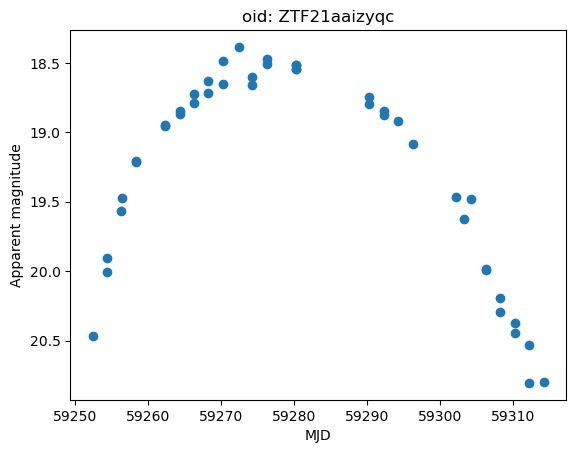

In [24]:
plot_light_curve(one_light_curve, one_light_curve.oid.unique()[0])

In [25]:
class SinteticLigthCurve:
    def __init__(self,tpt,a0,w0,p0,m0,P,Q,R):
        self.a0 = a0
        self.w0 = w0
        self.tpt = tpt
        self.p0 = p0
        self.m0 = m0
        self.P = P
        self.Q = Q
        self.R = R

    def olivares(self,t):
        f_fd = -self.a0/(1+np.exp((t-self.tpt)/self.w0))
        f_ld = self.p0*(t-self.tpt)+self.m0
        f_gs =  -self.P * np.exp(((t-self.Q)/self.R)**2)
        f = f_fd + f_ld  #+ f_gs
        return f

Revisar los oid: ZTF20aazpsur	

In [26]:
p0 = [95,1.744,3.602,0.008,14.482,1.675,102.148,-15.984] # tpt, a0, w0, p0, m0, P, Q, R

N = 10000
time_length = 300 # days

oid = []
mjd = []
mag = []

for n in range(N):
    increase_random = np.random.random()
    time = np.linspace(50, 150, time_length)
    po = [p0[0] + increase_random, p0[1] + increase_random, p0[2] + 0.01*increase_random, p0[3], p0[4] + 0.01*increase_random,
          p0[5] + 0.01*increase_random, p0[6] + 0.01*increase_random, p0[7] + 0.01*increase_random]
    #print(po)
    synthetic_lc = SinteticLigthCurve(po[0],po[1],po[2],po[3],po[4],po[5],po[6],po[7])
    f = synthetic_lc.olivares(time)
    mjd.append(np.array(time))
    mag.append(np.array(f))

# Crear una lista vacía para almacenar los datos
train_data_synthetic = []
test_data_synthetic  = []

# Iterar sobre cada conjunto de tiempo y brillo
for i in range(len(mjd)):
    time_set = mjd[i]
    brightness_set = mag[i]
    code = 'ZTF' + str(i + 1)  # Código de pertenencia (del 1 al 8000)
    for time, brightness in zip(time_set, brightness_set):
        if i+1 <= 8_000:
          train_data_synthetic.append([code, time, brightness])
        else:
          test_data_synthetic.append([code, time, brightness])

# Crear el DataFrame
train_data_synthetic = pd.DataFrame(train_data_synthetic, columns=['oid','mjd', 'magpsf'])
test_data_synthetic = pd.DataFrame(test_data_synthetic, columns=['oid','mjd', 'magpsf'])
train_data_synthetic['sigmapsf'] = 0.001
test_data_synthetic['sigmapsf'] = 0.001

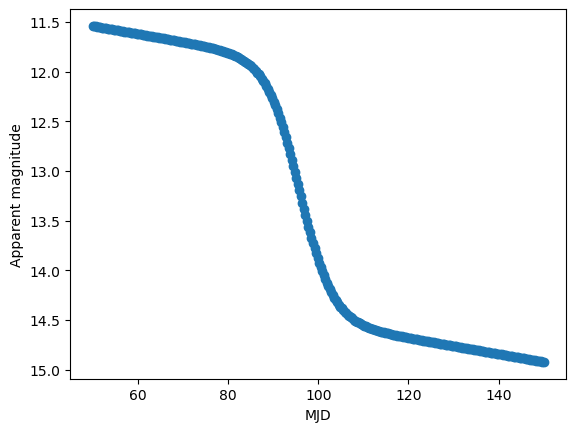

In [27]:
plot_light_curve(train_data_synthetic[train_data_synthetic.oid == train_data_synthetic.oid.unique()[2]])

In [28]:
def create_matrix(data, time_length):
    # Crear una columna de arrays en el DataFrame agrupado
    grouped = data.groupby('oid').apply(lambda x: x.sort_values(by='mjd')[['mjd', 'magpsf']].values)

    # Convertir el resultado en una matriz tridimensional (num_series, time_length, 2)
    matrix = np.full((len(grouped), time_length, 2), np.nan)
    
    for i, array in enumerate(grouped):
        matrix[i, :array.shape[0], :] = array

    return matrix

matrix_train = create_matrix(train_data_synthetic, 300)
matrix_test = create_matrix(test_data_synthetic, 300)

In [29]:
matrix_train

array([[[ 50.        ,  11.38525384],
        [ 50.33444816,  11.38793021],
        [ 50.66889632,  11.39060665],
        ...,
        [149.33110368,  14.91863726],
        [149.66555184,  14.92131294],
        [150.        ,  14.92398861]],

       [[ 50.        ,  11.42762595],
        [ 50.33444816,  11.43030231],
        [ 50.66889632,  11.43297875],
        ...,
        [149.33110368,  14.91855238],
        [149.66555184,  14.92122805],
        [150.        ,  14.92390372]],

       [[ 50.        ,  11.50010643],
        [ 50.33444816,  11.50278279],
        [ 50.66889632,  11.50545922],
        ...,
        [149.33110368,  14.91840717],
        [149.66555184,  14.92108285],
        [150.        ,  14.92375851]],

       ...,

       [[ 50.        ,  11.62508845],
        [ 50.33444816,  11.6277648 ],
        [ 50.66889632,  11.63044122],
        ...,
        [149.33110368,  14.91815679],
        [149.66555184,  14.92083246],
        [150.        ,  14.92350811]],

       [[ 50.  

In [30]:
class ModelV1(nn.Module):

    """ This model will use Conv1d to encode and decode the NN
    The Output Size using Conv1d in Pytorch could be calculate using
    
    output_size = [(input_size - kernel_size + 2*padding)/stride] +1  
    
    
    """

    def __init__(self, input_size:int, latent_size:int,  **kwargs) -> None:
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=4, dilation=1, padding=2*1), # Output size: [batch_size, 16, input_dim //2]
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, dilation=1, padding=2*1), # Output size: [batch_size, 16, input_dim //4]
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, dilation=1, padding=2*1), # Output size: [batch_size, 16, input_dim //4]
            nn.ReLU(),
        )

        self.encode_mean   = nn.Linear(in_features=64*(input_size // 8), out_features=latent_size)
        self.encode_logvar = nn.Linear(in_features=64*(input_size // 8), out_features=latent_size)

        # Decoder
        self.decoder_input = nn.Linear(in_features=input_size, out_features= 64 * (input // 8))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, dilation=1, padding=2*1)
            nn.ReLu()

        ) 

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.encode_mean(x), self.encode_logvar(x)
        return mean, logvar

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder_input(z)
        result = result.view(self.hidden_dims[0], self.conv_out_size)
        result = self.decoder(result)
        result = self.final_layer(result)
        # Transpose output back to [300, 2]
        return result.transpose(0, 1)

    def reparameterize(self, mean: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, input: torch.Tensor, **kwargs) -> list[torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2684106225.py, line 31)

In [31]:
class ModelV0(nn.Module):

    def __init__(self, input_size, hidden_dim, latent_size, device):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=latent_size),
            nn.ReLU()
            )

        # latent mean and variance
        # Acá tenia un dos en
        mu_size, logvar_size = 3, 3
        self.encode_mean_layer = nn.Linear(in_features=latent_size, out_features=2)
        self.encode_logvar_layer = nn.Linear(in_features=latent_size, out_features=2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=latent_size),
            nn.ReLU(),
            nn.Linear(in_features=latent_size, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=input_size),
            )

    def encode(self, x):
        x = self.encoder(x)
        
        #print('Entro al Encoder')
        #print(x.shape)
        mean, logvar = self.encode_mean_layer(x), self.encode_logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        #print('Esta parametrizando al Encoder')
        # Var(x) = std**2 -> 0.5*ln(Var(x)) = ln(std)
        # std = exp(0.5*ln(Var(x))) 
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mean + eps*std
        return z

    def decode(self, x):
        #print('Entro al DeEncoder')
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [32]:
def custom_collate_fn(batch):
    # `batch` es una lista de DataFrames, uno por cada oid
    X_batch = []
    X_weights_batch = []
    for _, group_oid in batch:
        X = group_oid[['mjd', 'magpsf', 'sigmapsf']]
        X = process_light_curve_parsnip(X)
        X, X_weights = create_grid(X)
        X_batch.append(torch.tensor(X, dtype=torch.float32).T)
        X_weights_batch.append(torch.tensor(X_weights, dtype=torch.float32).T)

    # Stackea todas las matrices para formar un batch
    X_batch = torch.stack(X_batch)
    X_weights_batch = torch.stack(X_weights_batch)

    return X_batch, X_weights_batch

In [34]:
input_size = 2
h_dim = 200
z_dim = 20
num_epoch = 5
batch_size = 32
learning_rate = 1e-4 

model = ModelV0(input_size=input_size, hidden_dim=h_dim, latent_size=z_dim, device=device)
#model = ModelV1(in_channels = input_dim, latent_dim = z_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train_dataloader = DataLoader(train_data_synthetic.groupby('oid'), batch_size=32)

In [35]:
for batch in train_dataloader:
    print(batch)
    break

NameError: name 'train_dataloader' is not defined

In [36]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ModelV0                                  --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       600
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       4,020
│    └─ReLU: 2-4                         --
├─Linear: 1-2                            42
├─Linear: 1-3                            42
├─Sequential: 1-4                        --
│    └─Linear: 2-5                       60
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       4,200
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       402
Total params: 9,366
Trainable params: 9,366
Non-trainable params: 0

In [37]:
len(train_data_synthetic)

2400000

In [38]:
len(train_data_synthetic.oid.unique())

8000

In [40]:
#X = train_data_synthetic[train_data_synthetic.oid == train_data_synthetic.oid.unique()[0]][['mjd','magpsf','sigmapsf']]
#X = process_light_curve_parsnip(X)
#print(X)
X, X_weights = create_grid(train_data_synthetic)
#print(X)
X = torch.tensor(X, dtype=torch.float32)
X = X.T
X_weights = X_weights.T
#print(X_weights.shape)
#X_weights[:,0]

KeyError: 'time_index'

In [ ]:
def loss_function(X_reconstructed, X_weights,mu,logvar):
    
#     print('X_reconstructed:\nType:',type(X_reconstructed),\
#           '\nShape:',X_reconstructed.shape)
#     print('X_weights:\nType',type(X_weights),\
#           '\nShape:',X_weights.shape)
      nll = (0.5 * X_weights[:,1] * X_reconstructed[:,1]**2)
      kl_div = -0.5 * (1 + logvar - mu**2 - torch.exp(logvar)**2)

      nll = torch.sum(nll)
      #print(nll)
      kl_div = torch.sum(kl_div)
      #print(kl_div)

      return nll + kl_div

In [ ]:
def replace_nan_grads(parameters, value=0.0):
    """Replace NaN gradients

    Parameters
    ----------
    parameters : Iterator[torch.Tensor]
        Model parameters, usually you can get them by `model.parameters()`
    value : float, optional
        Value to replace NaNs with
    """
    for p in parameters:
        if p.grad is None:
            continue
        grads = p.grad.data
        grads[torch.isnan(grads)] = value

In [ ]:
train_losses = []
for epoch in tqdm(range(num_epoch)):
    # Set the model to training mode
    model.train()
    for oid, group_oid in train_data_synthetic.groupby('oid'):
        X = group_oid[['mjd','magpsf','sigmapsf']]
        X = process_light_curve_parsnip(X)
        X, X_weights = create_grid(X)
        #time = X[0,:]
        X = torch.tensor(X, dtype=torch.float32)
        X_weights = torch.tensor(X_weights, dtype=torch.float32)
        X = X.T
        X_weights = X_weights.T
        #print('Input shape:',X.shape)
        #print(X[:,0].max())
        #print(X.shape)
        # Forward pass
        #X = X.to(device)

        #try:
        #mag_reconst, mu, logvar = model(X)
        #print('Reconstructed shape:',X_reconst.shape)
        #print(X_reconst[:,0].max())

        #X_reconst = torch.cat([torch.tensor(time, dtype=torch.float32).unsqueeze(1), mag_reconst], dim=1)
        
        # Cálculo de la pérdida
        loss = loss_function(X_reconst, X_weights, mu, logvar)
        
        # Backprop y optimización
        optimizer.zero_grad()
        loss.backward()
        replace_nan_grads(model.parameters())
        optimizer.step()
        #print('Paso una vez')
        #except:
        #    print(f'No se pudo con {oid}')
        #    pass
    
    train_losses.append(loss.item())
        
    # Puedes añadir un mensaje de final de epoch aquí si lo deseas
    #if epoch % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item()/300:.4f}')

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'X_reconst' is not defined

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_epoch), np.array(train_losses)/300)
ax.set_xlabel('Epochs')
ax.set_ylabel('Train loss')

In [ ]:
def plot_curves(time, original_magnitude, reconstructed_magnitude, title='Curvas Originales y Reconstruidas'):
    plt.figure(figsize=(12, 6))
    plt.plot(time, original_magnitude, label='Original', linestyle='--', color='blue')
    plt.plot(time, reconstructed_magnitude, label='Reconstruido', linestyle='-', color='red')
    plt.xlabel('Tiempo')
    plt.ylabel('Magnitud')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
model.eval()

# Definir una lista para almacenar las pérdidas de cada muestra de prueba
test_losses = []

# Definir una lista para almacenar las reconstrucciones de las muestras de prueba
reconstructions = []

#with torch.inference_mode():
with torch.inference_mode():
    for _, group_oid in test_data_synthetic.groupby(by='oid'):
        X = group_oid[['mjd','magpsf','sigmapsf']]
        #X = process_light_curve_atat(X)# Karpathy constant is just a joke
        X = process_light_curve_parsnip(X)
        X, X_weights = create_grid(X)
        time = X[0,:]
        original_magnitude = X[1,:]
        X = torch.tensor(X, dtype=torch.float32)
        X_weights = torch.tensor(X_weights, dtype=torch.float32)
        X = X.T
        X_weights = X_weights.T

        # Forward pass
        X_reconstructed, mu, logvar = model(X)

        #print(X_reconstructed)
        # Convierte las predicciones a numpy
        reconstructed_magnitude = X_reconstructed.cpu().numpy()[:,0]  # Segunda fila para magnitud
        #print(len(reconstructed_magnitude))
        
        # Grafica
        plot_curves(time, original_magnitude, reconstructed_magnitude, title=f'Curvas para OID {oid}')
        
        # Sal de la iteración si solo deseas graficar para un OID
        break

        # Compute loss
        loss = loss_function(X_reconstructed, X_weights, mu, logvar)
        #replace_nan_grads(model.parameters())

        # Guardar la pérdida y las reconstrucciones
        test_losses.append(loss.item())
        reconstructions.append(X_reconstructed.cpu().numpy())

    # Calcular la pérdida promedio en los datos de prueba
    average_test_loss = np.mean(test_losses)
    print("Average test loss:", average_test_loss)

In [ ]:
reconstructions = np.array(reconstructions)
len(reconstructions[0][:,0]), len(reconstructions[0][:,1])

In [ ]:
reconstructions[0][:,0]

In [ ]:
sample_index = 2
sample_data = test_data_synthetic[test_data_synthetic.oid == test_data_synthetic.oid.unique()[sample_index]]
sample_data = process_light_curve_parsnip(sample_data)
sample_data, _ = create_grid(sample_data)
sample_reconstruction = reconstructions[sample_index]

fig, ax = plt.subplots()

ax.plot(sample_data[0,:], sample_data[1,:], 'o', color='C0')
ax.plot(np.linspace(0,300,300), sample_reconstruction[:,1], 'o', color='C1')

ax.set_xlabel('Time')
ax.set_ylabel('Flux')
ax.set_title('Original vs. Reconstructed Flux')
#ax.legend()
#ax.invert_yaxis()
plt.show()